In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category='SettingWithCopyWarning')
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np

In [2]:
sys.path.append(os.getenv('DEV_HOME'))
sys.path.append(os.getenv('SITES_HOME'))

In [3]:
import covid_ont
from covid_ont import dataset_read, dataset_get, DIR_IMAGES, FIGSIZES

In [4]:
ontario_pop_estimate=14755211 # Q1 2021, source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
forecast_depth=300

## Data

In [5]:
df=dataset_read('Vaccinations')
df.columns=['Date', 'Previous Day Doses Administered', 'Total Doses', 'Total Doses in Fully Vaccinated', 'Total Fully Vaccinated']
df.fillna(0, inplace=True)
df.set_index('Date', inplace=True)
df=df.astype(int)
df.index=pd.to_datetime(df.index)
df.insert(column='Percentage of Population Vaccinated with One Dose', loc=2, value=0)
df.insert(column='Percentage of Population Fully Vaccinated', loc=5, value=0)
df.tail()

,Previous Day Doses Administered,Total Doses,Percentage of Population Vaccinated with One Dose,Total Doses in Fully Vaccinated,Total Fully Vaccinated,Percentage of Population Fully Vaccinated
Date,,,,,,
2021-05-05,132603,5599723,0,762246,381123,0
2021-05-06,141038,5740761,0,769178,384589,0
2021-05-07,144724,5885485,0,774968,387484,0
2021-05-08,138125,6023610,0,781980,390990,0
2021-05-09,121075,6144685,0,785670,392835,0


In [6]:
df.shape

(132, 6)

In [7]:
df['Percentage of Population Vaccinated with One Dose']= df['Total Doses'].apply(lambda x: x*100/ontario_pop_estimate)
df['Percentage of Population Fully Vaccinated'] = df['Total Fully Vaccinated'].apply(lambda x: x*100/ontario_pop_estimate)
df.tail()

,Previous Day Doses Administered,Total Doses,Percentage of Population Vaccinated with One Dose,Total Doses in Fully Vaccinated,Total Fully Vaccinated,Percentage of Population Fully Vaccinated
Date,,,,,,
2021-05-05,132603,5599723,37.950816,762246,381123,2.582972
2021-05-06,141038,5740761,38.906668,769178,384589,2.606462
2021-05-07,144724,5885485,39.887501,774968,387484,2.626082
2021-05-08,138125,6023610,40.823611,781980,390990,2.649844
2021-05-09,121075,6144685,41.644169,785670,392835,2.662348


<AxesSubplot:xlabel='Date'>

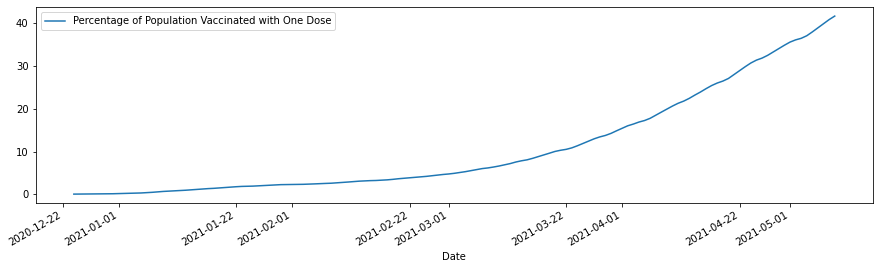

In [8]:
df[['Percentage of Population Vaccinated with One Dose']].plot(figsize=(15,4))

<AxesSubplot:xlabel='Date'>

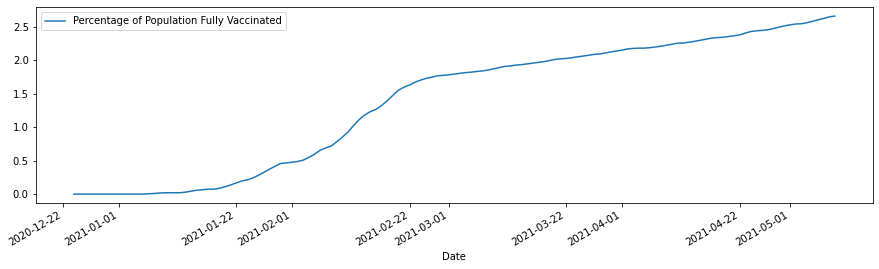

In [9]:
df[['Percentage of Population Fully Vaccinated']].plot(figsize=(15,4))

## Time Expanded 

In [10]:
df_future=df.append(pd.DataFrame([[0,0,0,0,0,0] for i in range(forecast_depth)], index=pd.date_range(start=df.index.max(), periods=forecast_depth, freq='D'), columns=df.columns))
df_future

,Previous Day Doses Administered,Total Doses,Percentage of Population Vaccinated with One Dose,Total Doses in Fully Vaccinated,Total Fully Vaccinated,Percentage of Population Fully Vaccinated
2020-12-24,0,10756,0.072896,0,0,0.0
2020-12-30,4595,18603,0.126077,0,0,0.0
2020-12-31,5463,23502,0.159279,0,0,0.0
2021-01-01,5415,28887,0.195775,0,0,0.0
2021-01-02,4305,33191,0.224944,0,0,0.0
...,...,...,...,...,...,...
2022-02-28,0,0,0.000000,0,0,0.0
2022-03-01,0,0,0.000000,0,0,0.0
2022-03-02,0,0,0.000000,0,0,0.0
2022-03-03,0,0,0.000000,0,0,0.0


<AxesSubplot:>

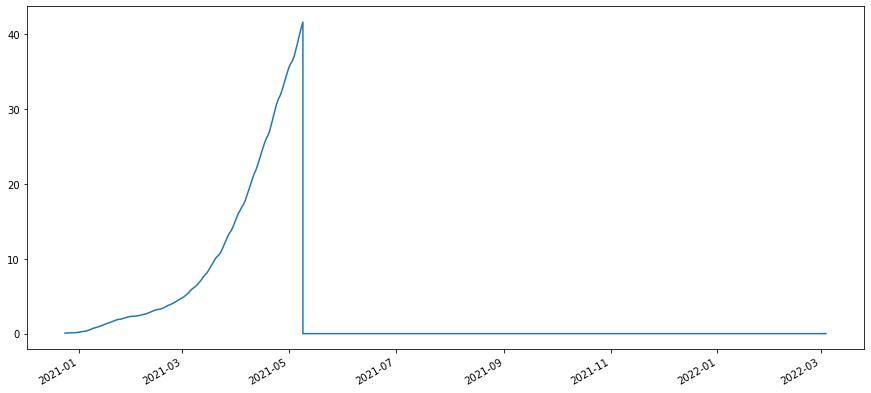

In [11]:
df_future['Percentage of Population Vaccinated with One Dose'].plot(figsize=(15,7))

## Model

In [12]:
X_act=np.reshape(df.index, (-1,1)) 
y_act=df['Percentage of Population Vaccinated with One Dose']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_act, y_act, test_size=0.8, random_state=42)

In [14]:
pipe=make_pipeline(PolynomialFeatures(degree=6), Ridge())
pipe.fit(X_train, y_train).score(X_test, y_test)

0.9980841118848165

In [15]:
yhat=pipe.predict(X_act)

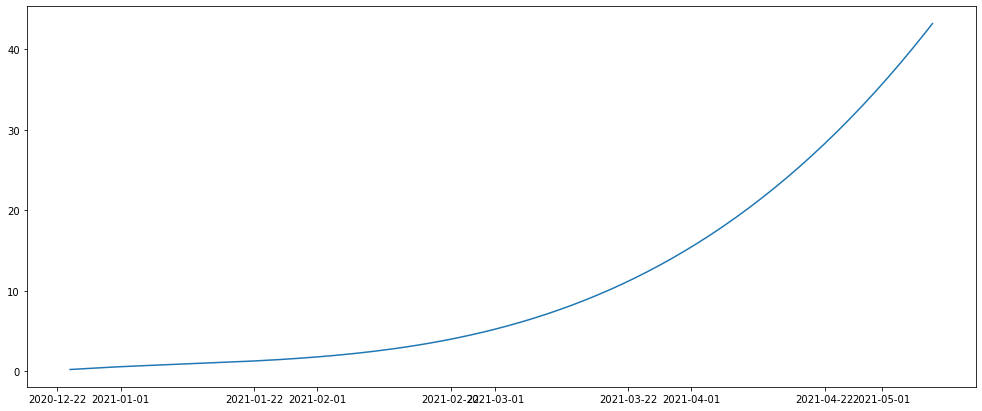

In [16]:
plt.figure(figsize=FIGSIZES)
plt.plot(df.index, yhat)

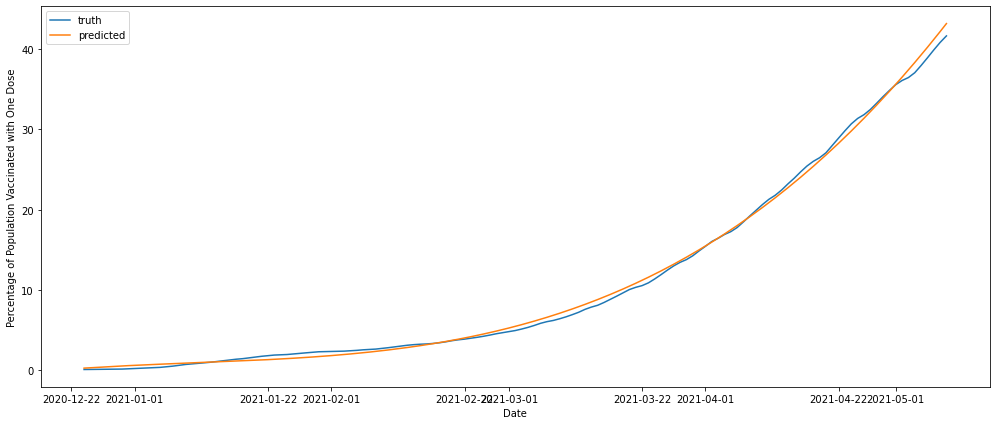

In [17]:
plt.figure(figsize=FIGSIZES)
sns.lineplot(x=df.index, y=y_act)
sns.lineplot(x=df.index, y=yhat)
plt.legend(['truth', 'predicted'])

In [18]:
df_future

,Previous Day Doses Administered,Total Doses,Percentage of Population Vaccinated with One Dose,Total Doses in Fully Vaccinated,Total Fully Vaccinated,Percentage of Population Fully Vaccinated
2020-12-24,0,10756,0.072896,0,0,0.0
2020-12-30,4595,18603,0.126077,0,0,0.0
2020-12-31,5463,23502,0.159279,0,0,0.0
2021-01-01,5415,28887,0.195775,0,0,0.0
2021-01-02,4305,33191,0.224944,0,0,0.0
...,...,...,...,...,...,...
2022-02-28,0,0,0.000000,0,0,0.0
2022-03-01,0,0,0.000000,0,0,0.0
2022-03-02,0,0,0.000000,0,0,0.0
2022-03-03,0,0,0.000000,0,0,0.0


In [36]:
df_future.index.max()

Timestamp('2022-03-04 00:00:00')

In [49]:
df.index.max()

Timestamp('2021-05-09 00:00:00')

## Prediction

In [75]:
df_pred=df_future[df_future.index>df.index.max()][['Percentage of Population Vaccinated with One Dose']]
df_pred

,Percentage of Population Vaccinated with One Dose
2021-05-10,0.0
2021-05-11,0.0
2021-05-12,0.0
2021-05-13,0.0
2021-05-14,0.0
...,...
2022-02-28,0.0
2022-03-01,0.0
2022-03-02,0.0
2022-03-03,0.0


In [76]:
X_pred=np.reshape(df_pred.index, (-1,1))
y_pred=pipe.predict(X_pred)

In [77]:
df_pred['Percentage of Population Vaccinated with One Dose']=y_pred
df_pred=df_pred[df_pred['Percentage of Population Vaccinated with One Dose']<101]
df_plot_pred=df_pred.copy()
df_plot_pred.columns=['Projection']

In [78]:
df_plot_act=df.copy()[['Percentage of Population Vaccinated with One Dose']]
df_plot_act.columns=['Actual']

In [79]:
peak=df_plot_pred[df_plot_pred.index==df_plot_pred.index.max()]
sevfive=df_plot_pred[df_plot_pred['Projection'].between(74, 76)]
fifty=df_plot_pred[df_plot_pred['Projection'].between(49,51)]
today=df_plot_act[df_plot_act.index==df_plot_act.index.max()]

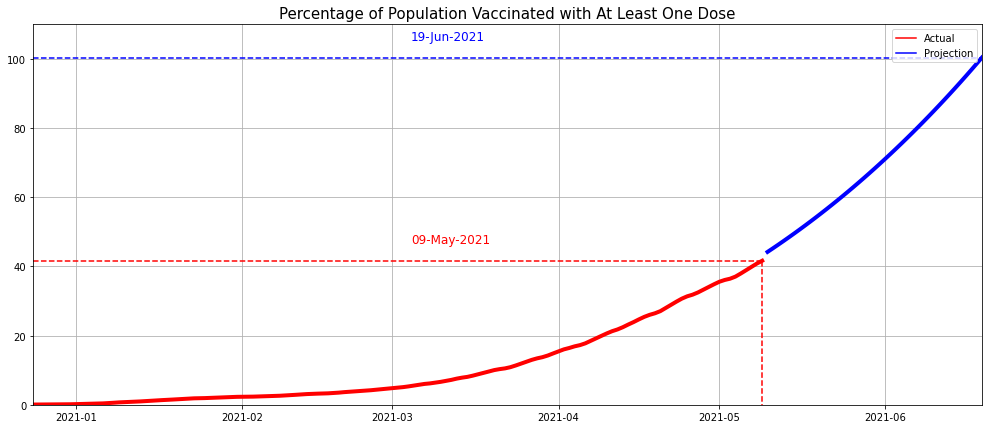

In [80]:
# Plot
arrowprops={'arrowstyle': '->', 'color': 'blue', 'lw': 4, 'ls': 'dashed'}
labels=['Actual', 'Projection']
plt.figure(figsize=FIGSIZES)
plt.title('Percentage of Population Vaccinated with At Least One Dose', fontsize=15)
ax=sns.lineplot(data=df_plot_act, palette=['red'], linewidth=4)
sns.lineplot(data=df_plot_pred, palette=['blue'], linewidth=4)
ax.set_xlabel('')
plt.xlim(df_plot_act.index[0], df_pred.index.max())
plt.legend(loc='best')
plt.ylim(0, 110)
plt.grid()

# plt.text(peak.index, 95, '100%', color='b', fontsize=14)
plt.text(df_plot_act.index.mean(), peak['Projection']+5, peak.index[0].strftime('%d-%b-%Y'), color='blue', fontsize=12)
plt.text(df_plot_act.index.mean(), today['Actual']+5, today.index[0].strftime('%d-%b-%Y'), color='red', fontsize=12)

ax.hlines(today['Actual'], df_plot_act.index[0], today.index[0], linestyles='dashed', color='red')
ax.hlines(peak['Projection'], df_plot_act.index.min(), df_plot_pred.index.max(), linestyles='dashed', color='blue')

plt.vlines(today.index[0], today['Actual'], 0, linestyles='dashed', color='red')
# plt.annotate(peak.index[0].strftime('%d-%b-%Y'), xy=(0.98, 0.91), xycoords='axes fraction', xytext=(0.8, 0.91), arrowprops=arrowprops, va='center', color='blue', fontsize=16)